In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

2024-09-04 17:40:32.961260: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 17:40:33.004092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]


In [3]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [4]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240731/'


# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
pc1_05 = all_df['PC1'].quantile(0.05)
pc1_95 = all_df['PC1'].quantile(0.95)
pc2_05 = all_df['PC2'].quantile(0.05)
pc2_95 = all_df['PC2'].quantile(0.95)

pc1_grid = np.linspace(pc1_05, pc1_95, 10)
pc2_grid = np.linspace(pc2_05, pc2_95, 10)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)

In [13]:
pc1_pc2_df 

,PC1,PC2,label
0,-15946.131405,8321.445352,metastructures
1,-15946.131405,6488.084918,metastructures
2,-15946.131405,4654.724485,metastructures
3,-15946.131405,2821.364051,metastructures
4,-15946.131405,988.003618,metastructures
...,...,...,...
95,12412.170597,-845.356816,metastructures
96,12412.170597,-2678.717249,metastructures
97,12412.170597,-4512.077683,metastructures
98,12412.170597,-6345.438116,metastructures


In [19]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240801_WeightMCMC_PCA_metastructures/'

stan_directory_esc = os.path.join(common_dir, 'ESC/stan_output')
stan_directory_cnc = os.path.join(common_dir, 'CNC/stan_output')
stan_directory_all = os.path.join(common_dir, 'all/stan_output')

esc_log_weights = load_weights(stan_directory_esc, 100)
cnc_log_weights = load_weights(stan_directory_cnc, 100)
all_log_weights = load_weights(stan_directory_all, 100)

esc_weights = np.mean(np.exp(np.array(esc_log_weights)), axis=(0, 1))
cnc_weights = np.mean(np.exp(np.array(cnc_log_weights)), axis=(0, 1))

# Put weights in a DataFrame
esc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values,  
                               'weight': esc_weights})
esc_weights_df['label'] = 'ESC'
cnc_weights_df = pd.DataFrame({'PC1': pc1_pc2_df['PC1'].values,
                               'PC2': pc1_pc2_df['PC1'].values, 
                               'weight': cnc_weights})
cnc_weights_df['label'] = 'CNC'


['20240715_WeightOptimization-20240801102525_1.csv', '20240715_WeightOptimization-20240801102525_2.csv', '20240715_WeightOptimization-20240801102525_3.csv', '20240715_WeightOptimization-20240801102525_4.csv']
['20240715_WeightOptimization-20240801102542_1.csv', '20240715_WeightOptimization-20240801102542_2.csv', '20240715_WeightOptimization-20240801102542_3.csv', '20240715_WeightOptimization-20240801102542_4.csv']
['20240715_WeightOptimization-20240801102600_1.csv', '20240715_WeightOptimization-20240801102600_2.csv', '20240715_WeightOptimization-20240801102600_3.csv', '20240715_WeightOptimization-20240801102600_4.csv']


In [15]:
esc_log_weights.shape

(4, 1000, 100)

In [20]:
esc_weights_all = np.exp(np.array(esc_log_weights))
cnc_weights_all = np.exp(np.array(cnc_log_weights))

esc_weights_all = esc_weights_all.reshape(-1, 100)
cnc_weights_all = cnc_weights_all.reshape(-1, 100)

esc_entropy_all = np.array([scipy.stats.entropy(x) for x in esc_weights_all])
cnc_entropy_all = np.array([scipy.stats.entropy(x) for x in cnc_weights_all])

# Put these data in dataframe 
esc_entropy_df = pd.DataFrame({'entropy': esc_entropy_all, 'label': 'ESC'})
cnc_entropy_df = pd.DataFrame({'entropy': cnc_entropy_all, 'label': 'NPC'})

In [21]:
all_entropy_df = pd.concat([esc_entropy_df, cnc_entropy_df], axis=0)

Means: []
Whiskers: []


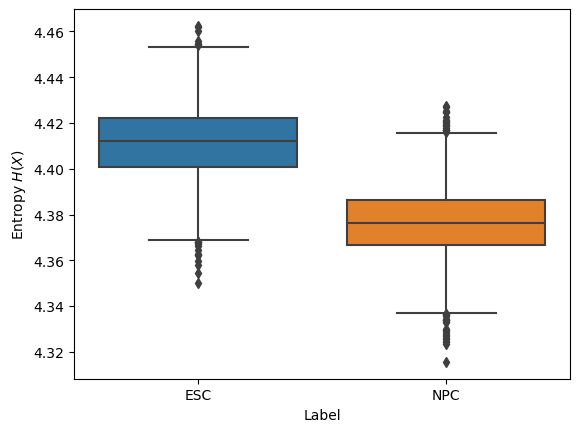

In [22]:
ax = sns.boxplot(x='label', y='entropy', data=all_entropy_df)

# Extract components
means = []
whiskers = []

# Loop through each box in the plot
for i, artist in enumerate(ax.artists):
    # The artist is the box, we can get the x-coordinates for the whiskers
    box_data = artist.get_path().vertices
    box_x = box_data[:, 0]
    box_y = box_data[:, 1]
    
    # The median is the middle line of the box
    median = ax.lines[2 * i + 1].get_ydata()[0]
    means.append(median)
    
    # The whiskers are the lines, each box has two whiskers
    whiskers.append([ax.lines[4 * i].get_ydata()[1], ax.lines[4 * i + 2].get_ydata()[1]])

print("Means:", means)
print("Whiskers:", whiskers)

plt.xlabel('Label')
plt.ylabel(r'Entropy $H(X)$')
plt.savefig(os.path.join(save_dir, 'entropy_boxplot_esc_cnc.png'), dpi=300, bbox_inches='tight')



In [10]:
ax.collections

<Axes.ArtistList of 0 collections>

In [11]:
esc_weights_grid = esc_weights_df['weight'].values.reshape(10, 10).T
cnc_weights_grid = cnc_weights_df['weight'].values.reshape(10, 10).T

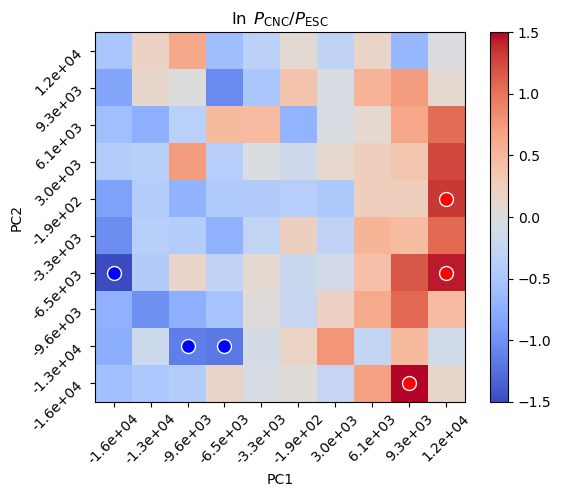

In [12]:
diff_table = np.log(cnc_weights_grid / esc_weights_grid)

# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[-10:]

# Convert the flattened indices back to 2D indices
top_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
top_10_indices = list(zip(top_10_indices[0], top_10_indices[1]))

# Flatten the array and get the indices of the top 10 values
flattened_indices = np.argsort(diff_table, axis=None)[:10]

# Convert the flattened indices back to 2D indices
bottom_10_indices = np.unravel_index(flattened_indices, diff_table.shape)

# Combine row and column indices into a list of tuples
bottom_10_indices = list(zip(bottom_10_indices[0], bottom_10_indices[1]))

plt.imshow(np.log(cnc_weights_grid / esc_weights_grid), cmap='coolwarm', vmin=-3/2, vmax=3/2)
plt.colorbar()
plt.xticks(np.arange(10), [f"{x:.1e}" for x in cnc_weights_df['PC1'].unique()], rotation=45)
plt.yticks(np.arange(10), [f"{x:.1e}" for x in cnc_weights_df['PC2'].unique()][::-1], rotation=45)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(r'$\ln \; P_\mathrm{CNC}/P_\mathrm{ESC}$')
plt.savefig(os.path.join(save_dir, 'prob_ratio.png'), dpi=300, bbox_inches='tight')

# Annotate the top 3 highest values
for i in range(1, 4):
    plt.scatter(top_10_indices[-i][1], top_10_indices[-i][0], color='red', s=100, edgecolor='white')
    # plt.text(top_10_indices[-i][0], top_3_coords[-i][1], f'{data[top_3_coords[0][i], top_3_coords[1][i]]:.2f}', 
    #          color='white', ha='center', va='center', fontsize=9, fontweight='bold')
    
for i in range(3):
    plt.scatter(bottom_10_indices[i][1], bottom_10_indices[i][0], color='blue', s=100, edgecolor='white')

plt.savefig(os.path.join(save_dir, 'cnc_esc_prob_ratio_annotate.png'), dpi=300, bbox_inches='tight')